<a href="https://colab.research.google.com/github/pranaya-mathur/Deep-Learning/blob/master/Toxic_Comments_using_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"chinki86","key":"2b37558d5b359235a655730a30d3156b"}'}

In [2]:
!ls -lha kaggle.json
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!pip install kaggle

!kaggle competitions download -c jigsaw-toxic-comment-classification-challenge

-rw-r--r-- 1 root root 64 Apr 20 14:25 kaggle.json
  0% 0.00/1.39M [00:00<?, ?B/s]
100% 1.39M/1.39M [00:00<00:00, 91.3MB/s]
 73% 17.0M/23.4M [00:00<00:00, 28.5MB/s]
100% 23.4M/23.4M [00:00<00:00, 47.7MB/s]
 38% 10.0M/26.3M [00:00<00:00, 25.8MB/s]
100% 26.3M/26.3M [00:00<00:00, 66.6MB/s]
  0% 0.00/1.46M [00:00<?, ?B/s]
100% 1.46M/1.46M [00:00<00:00, 207MB/s]


In [3]:
# Loading Glove Vectors

!wget http://nlp.stanford.edu/data/glove.6B.zip

--2019-04-20 14:34:05--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2019-04-20 14:34:05--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  90.6MB/s    in 9.1s    

2019-04-20 14:34:15 (90.0 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]



In [0]:
import zipfile
zip_ref = zipfile.ZipFile("glove.6B.zip", 'r')
zip_ref.extractall("glove vectors")
zip_ref.close()


In [0]:
zip_ref = zipfile.ZipFile("train.csv.zip", 'r')
zip_ref.extractall("train_data")
zip_ref.close()

In [6]:
# Importing the required Libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.models import Model
from keras.layers import Dense, Embedding, Input
from keras.layers import LSTM, Bidirectional, GlobalMaxPool1D, Dropout
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.optimizers import Adam
from sklearn.metrics import roc_auc_score

Using TensorFlow backend.


In [7]:
train_data = pd.read_csv("train_data/train.csv")
train_data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [0]:
MAX_SEQUENCE_LENGTH = 100
MAX_VOCAB_SIZE = 20000
EMBEDDING_DIM = 300
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 128
EPOCHS = 5

In [9]:
word2vec = {}
with open("glove vectors/glove.6B.300d.txt") as f:
  # is just a space-separated text file in the format:
  # word vec[0] vec[1] vec[2] ...
  for line in f:
    values = line.split()
    word = values[0]
    vec = np.asarray(values[1:], dtype='float32')
    word2vec[word] = vec
print('Found %s word vectors.' % len(word2vec))

Found 400000 word vectors.


In [0]:
sentences = train_data["comment_text"].fillna("DUMMY_VALUE").values
possible_labels = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
targets = train_data[possible_labels].values

In [0]:
# convert the sentences (strings) into integers
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences)

In [12]:
# get word -> integer mapping
word2idx = tokenizer.word_index
print('Found %s unique tokens.' % len(word2idx))

Found 210337 unique tokens.


In [13]:
# pad sequences so that we get a N x T matrix
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', data.shape)

Shape of data tensor: (159571, 100)


In [0]:
num_words = min(MAX_VOCAB_SIZE, len(word2idx) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx.items():
  if i < MAX_VOCAB_SIZE:
    embedding_vector = word2vec.get(word)
    if embedding_vector is not None:
      # words not found in embedding index will be all zeros.
      embedding_matrix[i] = embedding_vector


In [0]:
# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed
embedding_layer = Embedding(
  num_words,
  EMBEDDING_DIM,
  weights=[embedding_matrix],
  input_length=MAX_SEQUENCE_LENGTH,
  trainable=False
)


In [18]:
print('Building model...')

# create an LSTM network with a single LSTM
input_ = Input(shape=(MAX_SEQUENCE_LENGTH,))
x = embedding_layer(input_)
# x = LSTM(15, return_sequences=True)(x)
x = Bidirectional(LSTM(15, return_sequences=True))(x)
x = GlobalMaxPool1D()(x)
output = Dense(len(possible_labels), activation="sigmoid")(x)

model = Model(input_, output)
model.compile(
  loss='binary_crossentropy',
  optimizer=Adam(lr=0.01),
  metrics=['accuracy']
)


print('Training model...')
r = model.fit(
  data,
  targets,
  batch_size=BATCH_SIZE,
  epochs=EPOCHS,
  validation_split=VALIDATION_SPLIT
)


Building model...
Training model...
Train on 127656 samples, validate on 31915 samples
Epoch 1/5
127656/127656 [==============================] - 333s 3ms/step - loss: 0.0656 - acc: 0.9780 - val_loss: 0.0561 - val_acc: 0.9802
Epoch 2/5
127656/127656 [==============================] - 327s 3ms/step - loss: 0.0528 - acc: 0.9811 - val_loss: 0.0537 - val_acc: 0.9810
Epoch 3/5
127656/127656 [==============================] - 326s 3ms/step - loss: 0.0502 - acc: 0.9817 - val_loss: 0.0526 - val_acc: 0.9811
Epoch 4/5
127656/127656 [==============================] - 329s 3ms/step - loss: 0.0486 - acc: 0.9822 - val_loss: 0.0532 - val_acc: 0.9809
Epoch 5/5
127656/127656 [==============================] - 331s 3ms/step - loss: 0.0478 - acc: 0.9824 - val_loss: 0.0526 - val_acc: 0.9812


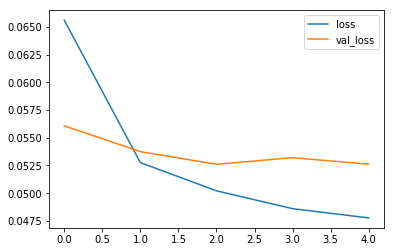

In [19]:
# plot some data
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

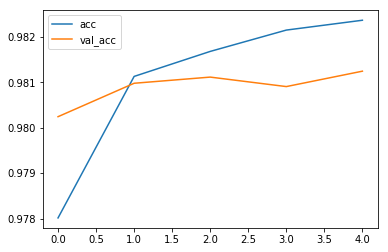

In [20]:
# accuracies
plt.plot(r.history['acc'], label='acc')
plt.plot(r.history['val_acc'], label='val_acc')
plt.legend()
plt.show()

In [0]:
p = model.predict(data)


In [23]:
aucs = []
for j in range(6):
    auc = roc_auc_score(targets[:,j], p[:,j])
    aucs.append(auc)
print(np.mean(aucs))

0.9808841020370122
